# Retention Time Prediction 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short walkthrough the process of reading a dataset and training a model for retention time prediction. The dataset is an example dataset extracted from a ProteomTools dataset generated in the **Chair of Bioanalytics** at the **School of Life Sciences** at the **Technical University of Munich**.

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

In [ ]:
# install the DLOmix package in the current environment using pip

#!python -m pip install -q dlomix==0.1.0

The available modules in the framework are as follows:

In [2]:
import numpy as np
import pandas as pd
import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
print([x for x in dir(dlomix) if not x.startswith("_")])


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



2024-04-25 14:29:49.913894: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-25 14:29:49.913918: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-25 14:29:49.913923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-25 14:29:49.913976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 14:29:49.914012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
wandb: WARNING The v1 API is deprecated and will be removed in a future release.  Please move to v2 by setting the env var WANDB_REPORT_API_ENABLE_V2=True.  This will be on by defau

['META_DATA', 'constants', 'data', 'eval', 'layers', 'losses', 'models', 'pipelines', 'reports', 'utils']


- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around TensorFlow Dataset
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations for Retention Time Prediction
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)
- `utils`: helper modules

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

## 1. Load Data

We can import the dataset class and create an object of type `RetentionTimeDataset`. This object wraps around a Hugging Face dataset that can generate TensorFlow Dataset objects or Torch Dataset for training, validation, or testing. This can be controlled by the arguments `val_ratio`, `val_data_source`, and `test_data_source`.

In [3]:
from dlomix.data import RetentionTimeDataset

In [4]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              sequence_column="sequence",
                              label_column="irt",
                              data_format="csv",
                              max_seq_len=30,
                              batch_size=BATCH_SIZE,
                              encoding_scheme="naive-mods",
                              val_ratio=0.2)

Mapping SequenceParsingProcessor (num_proc=10):   0%|          | 0/27200 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor (num_proc=10):   0%|          | 0/6800 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor (num_proc=10):   0%|          | 0/27200 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor (num_proc=10):   0%|          | 0/6800 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor (num_proc=10):   0%|          | 0/27200 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor (num_proc=10):   0%|          | 0/6800 [00:00<?, ? examples/s]

Filter (num_proc=10):   0%|          | 0/27200 [00:00<?, ? examples/s]

Filter (num_proc=10):   0%|          | 0/6800 [00:00<?, ? examples/s]

Now we have an RT dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.tensor_rain_data` and `.tensor_val_data`.

In [5]:
"Hugging Face Dataset", rtdata

('Hugging Face Dataset',
 DatasetDict({
     train: Dataset({
         features: ['sequence', 'irt', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
         num_rows: 26939
     })
     val: Dataset({
         features: ['sequence', 'irt', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
         num_rows: 6732
     })
 }))

In [6]:
 "Training examples", len(rtdata["train"])

('Training examples', 26939)

In [7]:
 "Training examples", len(rtdata["val"])

('Training examples', 6732)

In [8]:
i = int(input())
rtdata["train"]["sequence"][i], 



 1


([21,
  8,
  10,
  17,
  1,
  1,
  1,
  10,
  2,
  7,
  5,
  17,
  16,
  8,
  4,
  18,
  18,
  9,
  22,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],)

## 2. Model

We can now create the model. We will use a simple Prediction with a conv1D encoder. It has the default working arguments, but most of the parameters can be customized.

**Note**: Important is to ensure that the padding length used for the dataset object is equal to the sequence length passed to the model.

In [9]:
from dlomix.models import PrositRetentionTimePredictor

In [10]:
model = PrositRetentionTimePredictor(seq_length=30)

## 3. Training

We can then train the model like a standard Keras model. The optimizer parameters here are from Prosit, but other optimizer parameters can be used.  

In [11]:
#imports

from dlomix.eval import TimeDeltaMetric

In [12]:
# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric

# you can also import tensorflow and build your custom optimizer object and pass it

model.compile(optimizer='adam', 
              loss='mse',
              metrics=[TimeDeltaMetric()])

We store the result of training so that we can explore the metrics and the losses later. We can pass the attributes `tensor_train_data` and `tensor_val_data`, where each returns the corresponding TensorFlow Dataset object.

In [13]:
history = model.fit(rtdata.tensor_train_data,
                    validation_data=rtdata.tensor_val_data,
                    epochs=2)

Epoch 1/2


/Users/Omar/miniconda3/envs/dlx/lib/python3.11/site-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
2024-04-25 14:30:10.669058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


421/421 [==============================] - 18s 35ms/step - loss: 1421.9014 - timedelta: 29.3405 - val_loss: 166.6795 - val_timedelta: 10.4834
Epoch 2/2
421/421 [==============================] - 14s 33ms/step - loss: 164.4684 - timedelta: 10.1793 - val_loss: 152.7002 - val_timedelta: 11.5996


## 3. Testing and Reporting

We can create a test dataset to test our model. Additionally, we can use the reporting module to produce plots and evaluate the model.

Note: the reporting module is still in progress and some functionalities might easily break.

In [14]:
# create the dataset object for test data

TEST_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_test.csv'

test_rtdata = RetentionTimeDataset(test_data_source=TEST_DATAPATH,
                                   data_format="csv",
                                   sequence_column="sequence",
                                   label_column="irt",
                                   max_seq_len=30, batch_size=32)

/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:278: UserWarning: Encoding scheme is EncodingScheme.UNMOD, this enforces removing all occurences of PTMs in the sequences.
If you prefer to encode the (amino-acids)+PTM combinations as tokens in the vocabulary, please use the encoding scheme 'naive-mods'.

  warnings.warn(


In [15]:
# use model.predict from keras directly on the testdata

predictions = model.predict(test_rtdata.tensor_test_data)

# we use ravel from numpy to flatten the array (since it comes out as an array of arrays)
predictions = predictions.ravel()

188/188 [==============================] - 3s 11ms/step


In [16]:
# we can get the targets of a specific split to calcualte evaluation metrics against predictions
# we access the underlying hugging face split named "test" in this case and access the label column "irt"

test_targets = test_rtdata["test"]["irt"]

In [17]:
test_targets[:5], predictions[:5]

([160.872622163197,
  -9.967313826645132,
  1.63019650045838,
  108.566268844221,
  14.7686069632344],
 array([154.758    ,   1.9171096,  -2.506313 , 123.70402  ,  22.940744 ],
       dtype=float32))

In [18]:
from dlomix.reports import RetentionTimeReport

In [19]:
# create a report object by passing the history object and plot different metrics
report = RetentionTimeReport(output_path="./output", history=history)

/var/folders/cc/ny50w1ls59q3_l6sr7l5h3r40000gp/T/ipykernel_4012/138508270.py:2: DeprecationWarning: RetentionTimeReport This class is deprecated and will not further developed. Use RetentionTimeReportWandb instead for creating a report with the Weights & Biases Report API.
  report = RetentionTimeReport(output_path="./output", history=history)


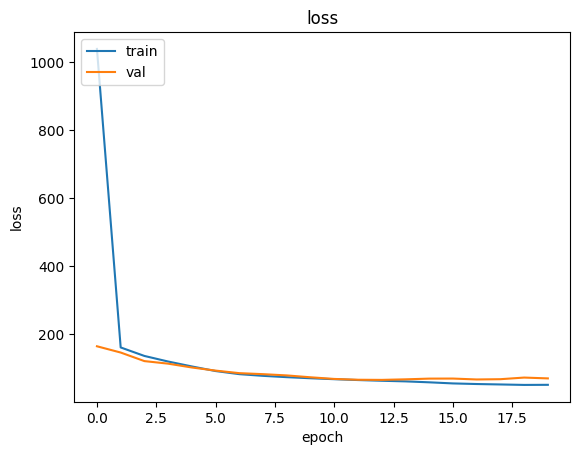

In [24]:
report.plot_keras_metric("loss")

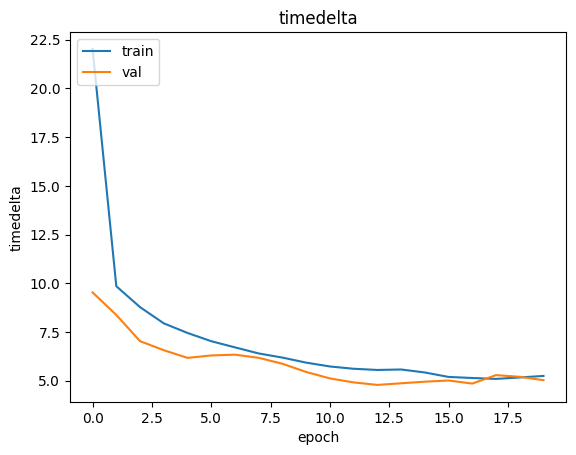

In [26]:
report.plot_keras_metric("timedelta")

In [27]:
# calculate R2  given the targets and the predictions of the test data
report.calculate_r2(test_targets, predictions)

0.9653832011351595

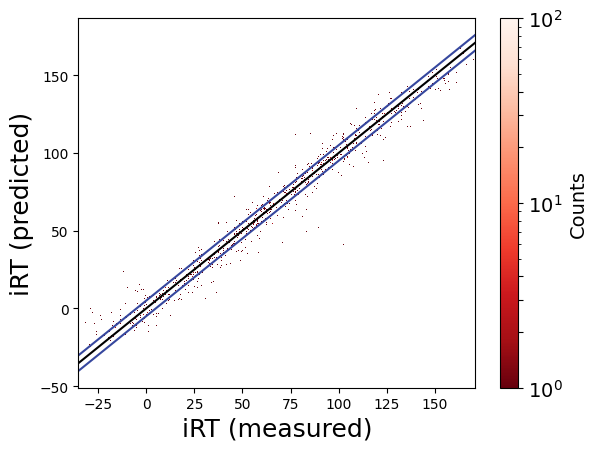

In [28]:
report.plot_density(test_targets, predictions)

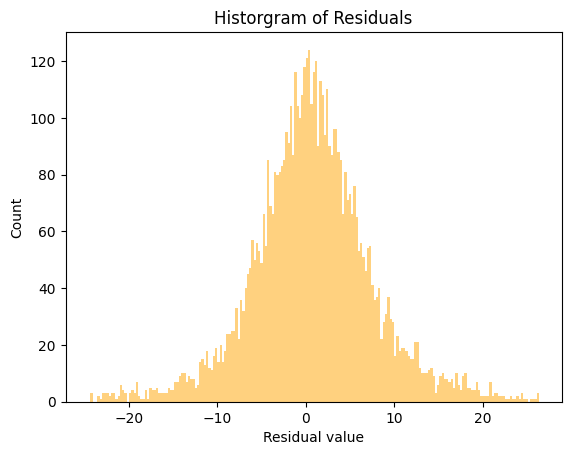

In [30]:
report.plot_residuals(test_targets, predictions) #xrange=(-30, 30))

## 4. Saving and Loading Models

Models can be saved normally the same Keras models would be saved. It is better to save the weights and the not the model since it makes it easier and more platform-indepdent when loading the model again. The extra step needed is to create a model object and then load the weights.

In [20]:
# save the model weights

save_path = "./output/rtmodel"
model.save_weights(save_path)

In [22]:
# models can be later loaded by creating a model object and then loading the weights

trained_model = PrositRetentionTimePredictor(seq_length=30)
trained_model.load_weights(save_path)

In [24]:
model.summary()

Model: "prosit_retention_time_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  400       
                                                                 
 sequential (Sequential)     (None, 30, 512)           1996800   
                                                                 
 attention_layer (Attention  multiple                  542       
 Layer)                                                          
                                                                 
 sequential_1 (Sequential)   (None, 512)               262656    
                                                                 
 dense_1 (Dense)             multiple                  513       
                                                                 
Total params: 2260911 (8.62 MB)
Trainable params: 2260911 (8.62 MB)
Non-trainable params: 0 (0.00 Byt

We can compare the predictions to make sure that the model was loaded correctly.

In [25]:
new_predictions = trained_model.predict(test_rtdata.tensor_test_data)

/Users/Omar/miniconda3/envs/dlx/lib/python3.11/site-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


188/188 [==============================] - 3s 12ms/step


In [26]:
new_predictions = new_predictions.ravel()

In [27]:
import numpy as np
# confirm all old and new predictions are the same
np.allclose(predictions, new_predictions)

True

In [ ]:
import pandas as pd
results_df = pd.DataFrame({"sequence": test_rtdata["test"]["sequence"],
                           "irt": test_rtdata["test"]["irt"],
                           "predicted_irt": predictions})

results_df.to_csv("./output/predictions_irt.csv", index=False)

In [ ]:
pd.read_csv("./output/predictions_irt.csv")